In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM,Bidirectional, Dropout, Activation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
%matplotlib inline

In [2]:
data = pd.read_csv('/kaggle/input/covid19-india/COVID-19_India_Data.csv')
data.set_index('date', inplace=True)
data.head()

,new_cases,cum_cases,new_death,cum_death,new_recovered,cum_recovered,cum_active_cases
date,,,,,,,
2020-01-30,1,1,0,0,0,0,1
2020-01-31,0,1,0,0,0,0,1
2020-02-01,0,1,0,0,0,0,1
2020-02-02,1,2,0,0,0,0,2
2020-02-03,1,3,0,0,0,0,3


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 2020-01-30 to 2021-10-31
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   new_cases         641 non-null    int64
 1   cum_cases         641 non-null    int64
 2   new_death         641 non-null    int64
 3   cum_death         641 non-null    int64
 4   new_recovered     641 non-null    int64
 5   cum_recovered     641 non-null    int64
 6   cum_active_cases  641 non-null    int64
dtypes: int64(7)
memory usage: 40.1+ KB


In [4]:
#daily new COVID cases

df = data[['new_cases']]
df.index = pd.to_datetime(df.index,format='%Y-%m-%d')
df.head()

,new_cases
date,
2020-01-30,1
2020-01-31,0
2020-02-01,0
2020-02-02,1
2020-02-03,1


In [5]:
df.tail()

,new_cases
date,
2021-10-27,16351
2021-10-28,14307
2021-10-29,14215
2021-10-30,12940
2021-10-31,12907


In [6]:
# Statistical summary
df.describe().style.background_gradient(cmap='prism')

,new_cases
count,641.000000
mean,53487.361934
std,78433.040215
min,0.000000
25%,12401.000000
50%,30820.000000
75%,55117.000000
max,414280.000000


In [7]:
#Displaying top 10 dates when the confirmed case counts were highest
t = df[["new_cases"]]
temp = t.sort_values(by=['new_cases'], ascending=False)
cm = sns.light_palette("Red", as_cmap=True)
temp.head(10).style.background_gradient(cmap=cm)

,new_cases
date,
2021-05-06 00:00:00,414280
2021-05-05 00:00:00,412624
2021-05-07 00:00:00,406901
2021-05-08 00:00:00,403808
2021-04-30 00:00:00,402014
2021-05-01 00:00:00,392576
2021-04-29 00:00:00,386773
2021-05-04 00:00:00,382847
2021-04-28 00:00:00,379404


Text(0, 0.5, 'No. of People infected')

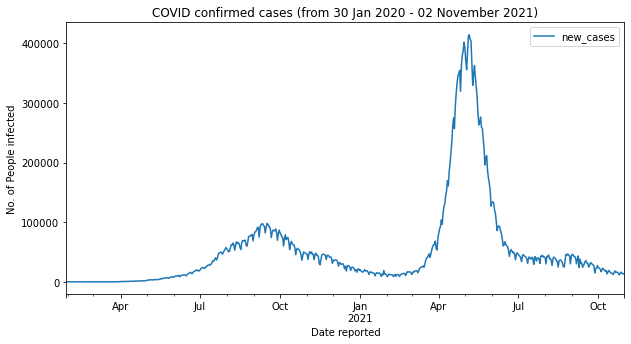

In [8]:
df.plot(figsize=(10,5),title="COVID confirmed cases (from 30 Jan 2020 - 02 November 2021)")
plt.xlabel("Date reported")
plt.ylabel('No. of People infected')

## Stationary

**Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.**

In [9]:
#Stationary
# We can then calculate the mean and variance
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=30958.065625, mean2=75946.473520
variance1=911575255.486318, variance2=10346019855.264874


We can see the mean and variance look very different. So It's a non-stationary time series data.

**In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.**


### Dickey-Fuller test
**Null Hypothesis (H0):** It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1):** It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

**p-value > 0.05:** Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= 0.05:** Reject the null hypothesis (H0), the data does not have a unit root and is stationary.



In [10]:
#Augmented Dickey-Fuller test
X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.712906
p-value: 0.071831
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


shows a negative value for the test statistic.

We can see that the value is larger than the critical values, meaning that we can fail to reject the null hypothesis and in turn that the time series is non-stationary.

### Transform into Stationary

In [11]:
df_log=np.sqrt(df["new_cases"])
df_diff=df_log.diff().dropna()

In [12]:
X = df_diff.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.223064
p-value: 0.018688
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


**In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.**

In [13]:
#Use data until 180 days before as training
x = len(df)-180

train=df.iloc[:x]
test = df.iloc[x:]

In [14]:
##scale or normalize data as the data is too skewed
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [15]:
#Sequence size has an impact on prediction, especially since COVID is unpredictable!
seq_size = 3  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1

## Use TimeSeriestrain_generator to generate data in sequences.
#Alternatively we can create our own sequences. 
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) 
print("Total number of samples in the generated data = ", len(train_generator)) 

Total number of samples in the original training data =  461
Total number of samples in the generated data =  458


In [16]:
#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=17)

In [17]:
#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 180 as we're using last 180 days for test
print("Total number of samples in the generated data = ", len(test_generator)) 

Total number of samples in the original training data =  180
Total number of samples in the generated data =  177


In [18]:
#Check data shape from generator
x,y = test_generator[0]
print(x,y)

[[[1.02639212]
  [1.03051138]
  [1.01215629]]] [[1.00446253]]


In [19]:
#Define Model 
model = Sequential()
model.add(LSTM(150, activation='relu',dropout=0.2, return_sequences=True, input_shape=(seq_size, n_features)))
# model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

2023-02-04 05:11:27.358818: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 150)            91200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________


In [20]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [21]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=100, callbacks=[es_callback, modelckpt_callback])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-02-04 05:11:28.361035: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
458/458 [==============================] - 8s 9ms/step - loss: 0.0114 - val_loss: 0.0011

Epoch 00001: val_loss improved from inf to 0.00105, saving model to model_checkpoint.h5
Epoch 2/100
458/458 [==============================] - 4s 9ms/step - loss: 0.0033 - val_loss: 0.0017

Epoch 00002: val_loss did not improve from 0.00105
Epoch 3/100
458/458 [==============================] - 4s 8ms/step - loss: 0.0049 - val_loss: 0.0010

Epoch 00003: val_loss improved from 0.00105 to 0.00101, saving model to model_checkpoint.h5
Epoch 4/100
458/458 [==============================] - 4s 9ms/step - loss: 0.0019 - val_loss: 0.0013

Epoch 00004: val_loss did not improve from 0.00101
Epoch 5/100
458/458 [==============================] - 4s 8ms/step - loss: 0.0022 - val_loss: 0.0011

Epoch 00005: val_loss did not improve from 0.00101
Epoch 6/100
458/458 [==============================] - 4s 8ms/step - loss: 0.0012 - val_loss: 0.0023

Epoch 00006: val_loss did not improve from 0.00101
Epoc

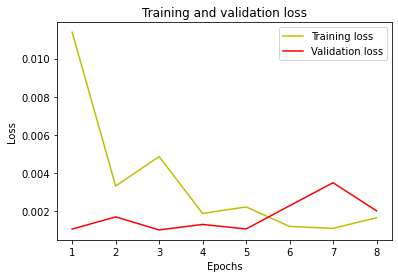

In [22]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 30 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [24]:
### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [25]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_cases","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_cases"] = test["new_cases"]

In [26]:
df_forecast

,actual_cases,predicted
date,,
2021-05-05,412624.0,284246.980212
2021-05-06,414280.0,268356.309657
2021-05-07,406901.0,253093.824315
2021-05-08,403808.0,220737.948688
2021-05-09,366455.0,206802.952698
...,...,...
2021-11-26,NaN,16417.354652
2021-11-27,NaN,16417.356149
2021-11-28,NaN,16417.354652


<AxesSubplot:title={'center':'Predictions for next 30 days'}, xlabel='date'>

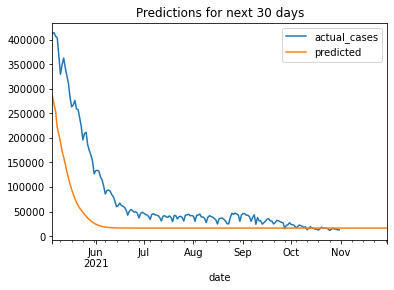

In [27]:
#Plot
df_forecast.plot(title="Predictions for next 30 days")

In [28]:
# error
df1 = df_forecast.dropna()

print(f'RMSE: {mean_squared_error(df1.actual_cases, df1.predicted, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(df1.actual_cases, df1.predicted)}')

RMSE: 71456.75064255307
MAPE: 0.5171795989451291
